#### a) Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.stats import norm
from datetime import datetime
from statsmodels.stats.stattools import jarque_bera
from statsmodels.multivariate.pca import PCA
from statsmodels.multivariate.factor import Factor
from statsmodels.multivariate.factor_rotation import rotate_factors
from statsmodels.tsa.arima.model import ARIMA

#### b) Importing data

In [3]:
#Importing data 
data = pd.read_csv('my_group_data copy.csv', index_col='Date', parse_dates=True, dayfirst=True)

#### c) Inspecting data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2532 entries, 2011-09-26 to 2021-09-24
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RIO.AX  2532 non-null   float64
 1   TLS.AX  2532 non-null   float64
 2   WES.AX  2532 non-null   float64
 3   CPU.AX  2532 non-null   float64
 4   SEK.AX  2532 non-null   float64
 5   WOW.AX  2532 non-null   float64
 6   CBA.AX  2532 non-null   float64
 7   WBC.AX  2532 non-null   float64
dtypes: float64(8)
memory usage: 178.0 KB


CPU, CBA and WBC series contained missing values as stocks haven't been trading (Trading Volume=0) on some few days over the past years. Therefore, we decided to proceed via imputation to resolve the issue.
Precisely, the missing values have been imputed with the last available adjusted closing price of the respective stock.

The reason for the choice is that past day prices are a good proxy and that on the secific day no market events could have happen to chnage the price.

Also, we decided not to proceed with the dropping of entire observations as the remaining stocks could have experience particular price behaviours on those specific days. Thus, potentially leading to the distortion of the analysis.

In [5]:
data.head()

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Date,,,,,,,,
2011-09-26,39.712032,1.942921,12.923607,5.573087,3.980642,17.424408,26.109711,11.411721
2011-09-27,41.836163,1.955703,13.381684,5.678382,4.223364,17.522896,27.121952,12.042071
2011-09-28,42.251755,1.974877,13.521650,5.731029,4.304272,17.642477,27.092180,12.279938
2011-09-29,41.196289,1.974877,13.428337,5.685903,4.263817,17.586203,27.098141,12.220470
2011-09-30,40.767490,1.981268,13.398647,5.618213,4.304272,17.487720,27.121952,12.095592


In [6]:
data.tail()

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Date,,,,,,,,
2021-09-20,95.239998,3.88,56.900002,16.280001,29.590000,39.209999,100.809998,25.299999
2021-09-21,95.709999,3.93,57.389999,16.510000,29.709999,39.360001,100.339996,25.190001
2021-09-22,98.269997,3.95,57.230000,16.330000,29.860001,39.250000,99.639999,24.910000
2021-09-23,98.860001,3.98,57.490002,16.930000,30.490000,39.060001,100.800003,25.070000
2021-09-24,99.330002,3.95,57.360001,17.900000,30.530001,39.290001,101.699997,25.250000


#### d) Calculating log-returns (%)

In [7]:
x = np.log(data).diff() * 100
x

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Date,,,,,,,,
2011-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-27,5.210688,0.655750,3.483130,1.871724,5.918904,0.563638,3.803614,5.376546
2011-09-28,0.988479,0.975614,1.040520,0.922870,1.897590,0.680110,-0.109830,1.956039
2011-09-29,-2.529770,0.000000,-0.692494,-0.790514,-0.944311,-0.319481,0.021998,-0.485440
2011-09-30,-1.046322,0.323089,-0.221343,-1.197638,0.944311,-0.561570,0.087832,-1.027140
...,...,...,...,...,...,...,...,...
2021-09-20,-3.669764,-1.025649,-0.665613,-2.247279,-3.421695,-0.458017,-2.032570,-2.266607
2021-09-21,0.492278,1.280426,0.857469,1.402887,0.404719,0.381829,-0.467315,-0.435725
2021-09-22,2.639598,0.507615,-0.279183,-1.096237,0.503615,-0.279864,-0.700070,-1.117779


In [8]:
# Taking out 1st row because it contains NaN values
log_r = x.iloc[1: , :]
log_r

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Date,,,,,,,,
2011-09-27,5.210688,0.655750,3.483130,1.871724,5.918904,0.563638,3.803614,5.376546
2011-09-28,0.988479,0.975614,1.040520,0.922870,1.897590,0.680110,-0.109830,1.956039
2011-09-29,-2.529770,0.000000,-0.692494,-0.790514,-0.944311,-0.319481,0.021998,-0.485440
2011-09-30,-1.046322,0.323089,-0.221343,-1.197638,0.944311,-0.561570,0.087832,-1.027140
2011-10-04,-4.636567,-3.278966,-5.031071,-4.238481,-4.027383,-1.826718,-4.582002,-5.041383
...,...,...,...,...,...,...,...,...
2021-09-20,-3.669764,-1.025649,-0.665613,-2.247279,-3.421695,-0.458017,-2.032570,-2.266607
2021-09-21,0.492278,1.280426,0.857469,1.402887,0.404719,0.381829,-0.467315,-0.435725
2021-09-22,2.639598,0.507615,-0.279183,-1.096237,0.503615,-0.279864,-0.700070,-1.117779


### Check PCA Feasibility


In [9]:
corr_matrix = data.corr().round(4)
corr_matrix

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
RIO.AX,1.0000,-0.2764,0.9430,0.7320,0.8643,0.8773,0.7615,0.1866
TLS.AX,-0.2764,1.0000,-0.0526,-0.0629,0.1065,-0.0999,0.3222,0.5921
WES.AX,0.9430,-0.0526,1.0000,0.7195,0.9361,0.8944,0.8710,0.3061
CPU.AX,0.7320,-0.0629,0.7195,1.0000,0.8255,0.6178,0.7882,0.6253
SEK.AX,0.8643,0.1065,0.9361,0.8255,1.0000,0.8121,0.9436,0.5441
WOW.AX,0.8773,-0.0999,0.8944,0.6178,0.8121,1.0000,0.7315,0.2043
CBA.AX,0.7615,0.3222,0.8710,0.7882,0.9436,0.7315,1.0000,0.7007
WBC.AX,0.1866,0.5921,0.3061,0.6253,0.5441,0.2043,0.7007,1.0000


To conduct PCA, thr correlated variables are required, but none of them are perfectly correlated. From the correalation matrix output, all the pairwise correlations are positive and not equal to 0 or 1, which indicates data is fit for PCA.

## Question 1: Principal Component Analysis (PCA)

In [10]:
#PCA Implementation
class MyPca:
    def __init__(self, log_r):
        self.log_r = log_r.values
        self.n = self.log_r.shape[0]
        self.d = self.log_r.shape[1]
        self.mu = np.mean(self.log_r, axis=0)
        self.eigval = None
        self.weight = None

    def fit(self):
        c = np.cov(self.log_r.T)
        eigval, weight = np.linalg.eig(c)
        idx = np.argsort(-eigval)
        self.eigval = eigval[idx]
        self.weight = weight[:, idx]
    
    def transform(self, n_comp):
        x = self.log_r - np.tile(self.mu, (self.n, 1))
        return np.dot(x, self.weight[:, :n_comp])
    
    def prop_var_explained(self):
        return self.eigval / np.sum(self.eigval)
    
    def biplot2d(self):
        ax = plt.axes()
        for i in range(self.d):
            w = self.weight[i, :]
            ax.plot([0, w[0]], [0, w[1]])
            ax.scatter(w[0], w[1])
        ax.axhline(y=0, color='k', alpha=0.6)
        ax.axvline(x=0, color='k', alpha=0.6)
        lim = np.max(np.abs(self.weight[:, :2]))
        lim = lim + 0.1 * lim
        ax.axis([-lim, lim, -lim, lim])
        ax.grid(True)
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        return ax
    
    def biplot3d(self):
        ax = plt.axes(projection="3d")
        for i in range(self.d):
            w = self.weight[i, :]
            ax.plot([0, w[0]], [0, w[1]], [0, w[2]])
            ax.scatter(w[0], w[1], w[2])
        lim = np.max(np.abs(self.weight[:, :3]))
        lim = lim + 0.1 * lim
        ax.axis([-lim, lim, -lim, lim])
        ax.set_zbound(lower=-lim, upper=lim)
        ax.plot([-lim, lim], [0, 0], [0, 0], 'k', alpha=0.6)
        ax.plot([0, 0], [-lim, lim], [0, 0], 'k', alpha=0.6)
        ax.plot([0, 0], [0, 0], [-lim, lim], 'k', alpha=0.6)
        ax.grid(True)
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
        return ax

In [11]:
# Weights
pca = MyPca(log_r)
pca.fit()
print(pca.weight)

[[-3.61952086e-01 -5.89550481e-01 -6.87647498e-01 -1.93609720e-01
   1.04274745e-01 -8.95024388e-03 -1.10972705e-02  7.95421051e-04]
 [-2.07058066e-01 -9.90869316e-02  3.11858630e-01 -2.09016877e-01
   3.37806313e-01 -8.13402636e-01  1.72164257e-01  3.14227953e-02]
 [-2.97131112e-01 -4.99696855e-02  2.93516800e-01 -1.75143499e-01
   2.19035165e-01  1.52726956e-01 -8.47708814e-01  4.97656166e-02]
 [-3.90293774e-01  4.74652073e-02 -3.08690644e-02  8.62971004e-01
   3.14684908e-01 -4.36124684e-03  2.50405213e-02 -8.56337666e-03]
 [-4.82940723e-01  7.63697257e-01 -3.30329707e-01 -2.64689506e-01
  -2.50987087e-02 -2.74162147e-02  5.37044235e-02  9.52621429e-03]
 [-2.49927414e-01 -1.01501469e-01  3.43170925e-01 -2.63156957e-01
   4.32017946e-01  5.59975193e-01  4.83812783e-01  7.70022089e-02]
 [-3.61499644e-01 -1.34194929e-01  2.43735063e-01 -8.80108852e-03
  -4.07038325e-01  2.00662294e-02  7.30331014e-02 -7.87660335e-01]
 [-3.98903585e-01 -1.62227517e-01  2.37674824e-01  6.35880839e-02
  -

In [12]:
c_name = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8']
tbl_pca = pd.DataFrame(pca.weight.round(4), index=data.columns, columns=c_name)
tbl_pca

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
RIO.AX,-0.3620,-0.5896,-0.6876,-0.1936,0.1043,-0.0090,-0.0111,0.0008
TLS.AX,-0.2071,-0.0991,0.3119,-0.2090,0.3378,-0.8134,0.1722,0.0314
WES.AX,-0.2971,-0.0500,0.2935,-0.1751,0.2190,0.1527,-0.8477,0.0498
CPU.AX,-0.3903,0.0475,-0.0309,0.8630,0.3147,-0.0044,0.0250,-0.0086
SEK.AX,-0.4829,0.7637,-0.3303,-0.2647,-0.0251,-0.0274,0.0537,0.0095
WOW.AX,-0.2499,-0.1015,0.3432,-0.2632,0.4320,0.5600,0.4838,0.0770
CBA.AX,-0.3615,-0.1342,0.2437,-0.0088,-0.4070,0.0201,0.0730,-0.7877
WBC.AX,-0.3989,-0.1622,0.2377,0.0636,-0.6124,-0.0150,0.0933,0.6083


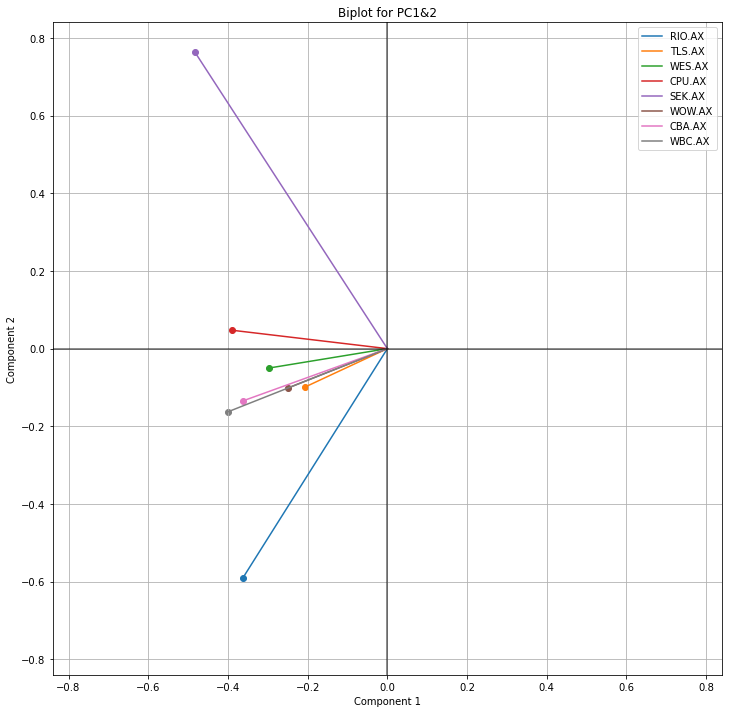

In [29]:
# Biplot
plt.figure(figsize=(12, 12))
pca.biplot2d()
plt.title('Biplot for PC1&2')
plt.legend(data.columns)
plt.show()

### Question a
Q: Present the results of your analysis in a table and describe the Principle components found. Do they have a relevant or useful interpretation?

A: According to the biplot,

PC1 is more likely to be a market factor

PC2 is more likely to be c=industry contrasting factor,contrasting RIO&WBC&CBA with SEK&CPU

In [13]:
tbl_mat = np.vstack([
        pca.eigval,
        pca.prop_var_explained(),
        np.cumsum(pca.prop_var_explained())])
tbl_eigval = pd.DataFrame(tbl_mat.round(4),
    index=['Eigenvalue', '% Variance', 'Cumulative'],
    columns=c_name)
tbl_eigval

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
Eigenvalue,8.2177,2.3483,1.9592,1.6777,1.3119,1.0134,0.6165,0.2974
% Variance,0.4711,0.1346,0.1123,0.0962,0.0752,0.0581,0.0353,0.0170
Cumulative,0.4711,0.6058,0.7181,0.8143,0.8895,0.9476,0.9830,1.0000


### Question b
Q: How many components would you choose.Justify your answer.

A: I woud choose 6 components becuase PC7 and PC8 have an eigenvalue which is less than 1, which indicates the maximum number of components would be 6. And the cumulative varianve for PC6 is 94.76%, which is quite reliable. 


### Question c
Q: What percentage of the total variance is captured by each component?

A: PC1 is capturing 47.11%; PC2 is capturing 13.46%; PC3 is capturing 11.23%; PC4 is capturing 9.62%; PC5 is capturing 7.52%; PC6 is capturing 5.81%; PC7 is capturing 3.53%; PC8 is capturing 1.7%

### Question d
Q: What is the cumulative percentage of the total variance captured by the first
m components, where m is the number you chose in part (b).

A: 94.76% 

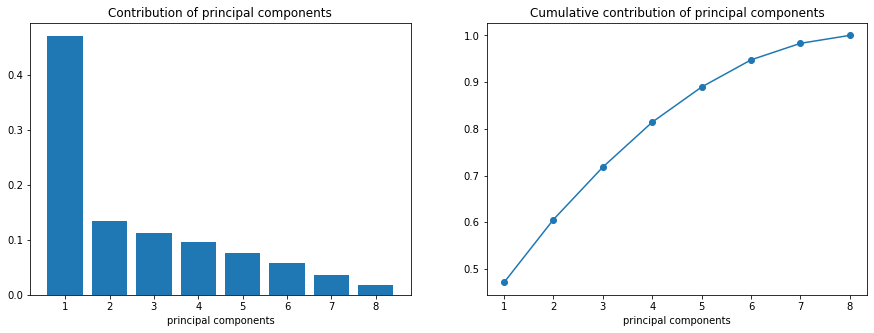

In [14]:
plt.figure(figsize=(15, 5))

number_of_components = len(pca.prop_var_explained())

plt.subplot(1, 2, 1)
plt.bar(np.arange(number_of_components) + 1, pca.prop_var_explained())
plt.title('Contribution of principal components')
plt.xlabel('principal components')

plt.subplot(1, 2, 2)
plt.plot(np.arange(number_of_components) + 1, np.cumsum(pca.prop_var_explained()), 'o-')
plt.title('Cumulative contribution of principal components')
plt.xlabel('principal components');
plt.show()

In [15]:
# Eigenvalues (explained variance)
print(pca.eigval)

[8.21772282 2.3482564  1.95921092 1.67774966 1.31186818 1.01340462
 0.61645128 0.29737693]


In [16]:
# Explained variance (%)
print(pca.prop_var_explained())

[0.47114457 0.13463197 0.11232693 0.09618999 0.075213   0.05810126
 0.03534284 0.01704943]


In [17]:
# Variation expalined by each individual component
pca.prop_var_explained()

array([0.47114457, 0.13463197, 0.11232693, 0.09618999, 0.075213  ,
       0.05810126, 0.03534284, 0.01704943])

In [18]:
# Cumulated Variation as we included more components
np.cumsum(pca.prop_var_explained())

array([0.47114457, 0.60577654, 0.71810348, 0.81429346, 0.88950646,
       0.94760772, 0.98295057, 1.        ])

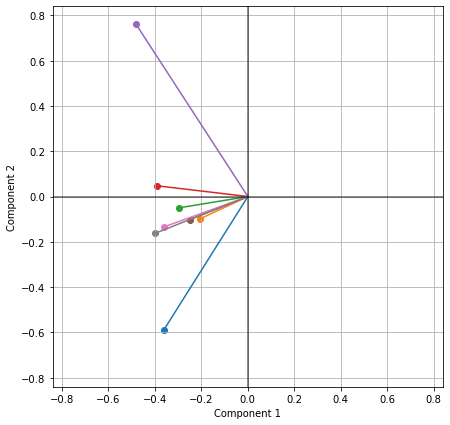

In [19]:
# Biplot
plt.figure(figsize=(7, 7))
pca.biplot2d()
plt.show()

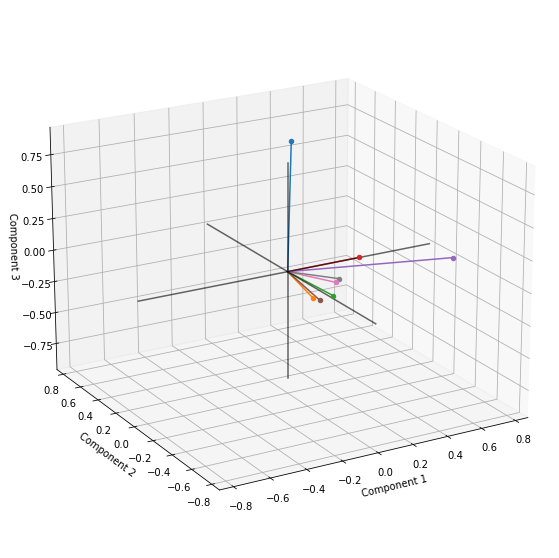

In [172]:
# 3D biplot
plt.figure(figsize=(10, 10))
ax = pca.biplot3d()
ax.view_init(20, -120)
plt.show()

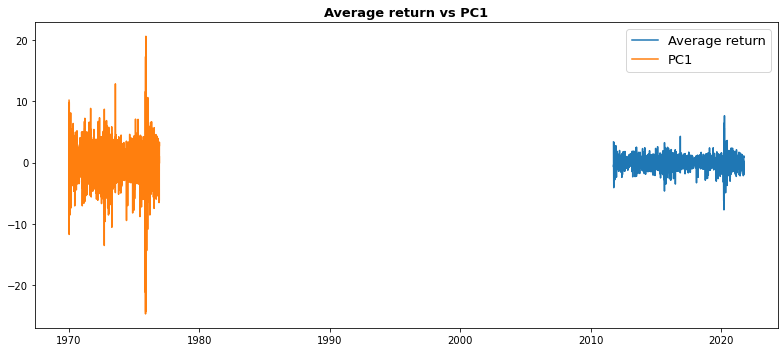

In [20]:
pc = pca.transform(n_comp=3)
pc[:,0] = (-1)*pc[:,0]

plt.figure(figsize=(11, 5))
plt.plot(log_r.mean(axis=1), label='Average return')
plt.plot(pc[:,0], label='PC1')
plt.title('Average return vs PC1', fontsize=13, weight='bold')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

## Question 1: Factor Analysis

In [21]:
# Sample correlation matrix 
log_r.corr()

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
RIO.AX,1.000000,0.219045,0.313160,0.325313,0.279959,0.259660,0.403502,0.400347
TLS.AX,0.219045,1.000000,0.432200,0.241640,0.238745,0.347203,0.386753,0.338723
WES.AX,0.313160,0.432200,1.000000,0.380599,0.404946,0.557080,0.563177,0.506858
CPU.AX,0.325313,0.241640,0.380599,1.000000,0.408073,0.278818,0.457882,0.462006
SEK.AX,0.279959,0.238745,0.404946,0.408073,1.000000,0.287734,0.432428,0.412324
WOW.AX,0.259660,0.347203,0.557080,0.278818,0.287734,1.000000,0.449792,0.369972
CBA.AX,0.403502,0.386753,0.563177,0.457882,0.432428,0.449792,1.000000,0.829803
WBC.AX,0.400347,0.338723,0.506858,0.462006,0.412324,0.369972,0.829803,1.000000


In [22]:
'''
Biplot for a given weight matrix
'''
def biplot(weight, labels=None):
    ax = plt.axes()
    for i in range(weight.shape[0]):
        w = weight[i, :]
        if labels is None:
            ax.plot([0, w[0]], [0, w[1]])
        else:
            ax.plot([0, w[0]], [0, w[1]], label=labels[i])
        ax.scatter(w[0], w[1])
    ax.axhline(y=0, color='k', alpha=0.6)
    ax.axvline(x=0, color='k', alpha=0.6)
    lim = np.max(np.abs(weight[:, :2]))
    lim = lim + 0.1 * lim
    ax.axis([-lim, lim, -lim, lim])
    ax.grid(True)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    return ax

'''
3D biplot for a given weight matrix
'''
def biplot3d(weight):
    ax = plt.axes(projection="3d")
    for i in range(weight.shape[0]):
        w = weight[i, :]
        ax.plot([0, w[0]], [0, w[1]], [0, w[2]])
        ax.scatter(w[0], w[1], w[2])
    lim = np.max(np.abs(weight[:, :3]))
    lim = lim + 0.1 * lim
    ax.axis([-lim, lim, -lim, lim])
    ax.set_zbound(lower=-lim, upper=lim)
    ax.plot([-lim, lim], [0, 0], [0, 0], 'k', alpha=0.6)
    ax.plot([0, 0], [-lim, lim], [0, 0], 'k', alpha=0.6)
    ax.plot([0, 0], [0, 0], [-lim, lim], 'k', alpha=0.6)
    ax.grid(True)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    return ax

### Question e

Q: For the 2-factor model, present the results of your analysis in a table and describe the factors found. Do they have a relevant or useful interpretation? Justify your answer.


### Question f
Q: Conduct the hypothesis test that the 2 factor model is appropriate for your data.

### Question g
Q: How many factors would you choose to include in your factor model?Justify your answer.

### Question h
Q: For the 2 factor model, what percent of variance is captured by the model?

### Question i
Q: For the 3 factor model, what is the Adjusted R-squared for asset 4?

### Question j

Q: For the 1 factor model, what is the specificity for asset 2?

### i) 1 factor (m=1)

In [23]:
#Fitting the Factor Analysis with m=1
fm1 = Factor(endog=log_r, n_factor=1, method='ml')
result1 = fm1.fit()

In [24]:
# Standardised factor loadings
result1.loadings

array([[0.46218488],
       [0.44021944],
       [0.63972847],
       [0.53246156],
       [0.50107263],
       [0.50681852],
       [0.91790347],
       [0.87496598]])

In [178]:
# Factor loadings (regression coefficients), i.e. rescaled to be on the scale of y (i.e. the returns data).
result1.loadings[:, 0] * log_r.std()

RIO.AX    0.786601
TLS.AX    0.535184
WES.AX    0.778773
CPU.AX    0.864942
SEK.AX    0.953479
WOW.AX    0.639696
CBA.AX    1.174866
WBC.AX    1.266303
dtype: float64

In [179]:
result1.uniqueness
ser2 = result1.uniqueness * log_r.var() 
ser = np.sqrt(ser2)
r2 = np.sqrt(result1.communality * log_r.var())     # re-scaled to be for actual data

tbl_r = pd.DataFrame({'Sample STD': data.std().round(4),
                      'Communal STD': r2.round(4),
                      'Specific STD' : ser.round(4)})
tbl_r.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample STD,25.3390,0.7571,11.4309,3.5124,6.5201,6.5430,15.3201,4.0893
Communal STD,0.7866,0.5352,0.7788,0.8649,0.9535,0.6397,1.1749,1.2663
Specific STD,1.5092,1.0916,0.9357,1.3750,1.6468,1.0881,0.5079,0.7007


In [180]:
r2 = result1.communality * log_r.var()    # re-scaled to be for actual data
communal_var = result1.communality * log_r.var()

tbl_r = pd.DataFrame({'Sample Variance': log_r.var().round(4),
                      'Communal Variance': communal_var.round(4),
                      'Specific Variance' : ser.round(4)**2})
tbl_r.T 

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample Variance,2.896500,1.478000,1.481900,2.638700,3.62090,1.593100,1.638300,2.09460
Communal Variance,0.618700,0.286400,0.606500,0.748100,0.90910,0.409200,1.380300,1.60350
Specific Variance,2.277685,1.191591,0.875534,1.890625,2.71195,1.183962,0.257962,0.49098


In [181]:
#Total data variance captured by FM m=1
total_data_variance = np.sum(log_r.var())
total_communal_variance = np.sum(result1.communality * log_r.var())
total_communal_variance / total_data_variance

0.3762141383153286

### ii) 2 factors (m=2)

In [182]:
#Fitting the Factor Analysis with m=2
fm2 = Factor(endog=log_r, n_factor=2, method='ml')
result2 = fm2.fit()

In [183]:
# Standardised factor loadings
result2.loadings

array([[-0.45732608, -0.06283236],
       [-0.43781005, -0.28695287],
       [-0.65879023, -0.48086763],
       [-0.52875564, -0.08631787],
       [-0.49563663, -0.15729244],
       [-0.50956777, -0.4459024 ],
       [-0.8967087 ,  0.04511492],
       [-0.91353048,  0.20663897]])

In [184]:
# Actual loadings with Factor 1 by (-1)
tbl_loading2 = pd.DataFrame({'Factor 1': round(result2.loadings[:,0] * log_r.std() * (-1), 4),
                             'Factor 2': round(result2.loadings[:,1] * log_r.std(), 4)})
tbl_loading2

,Factor 1,Factor 2
RIO.AX,0.7783,-0.1069
TLS.AX,0.5323,-0.3489
WES.AX,0.8020,-0.5854
CPU.AX,0.8589,-0.1402
SEK.AX,0.9431,-0.2993
WOW.AX,0.6432,-0.5628
CBA.AX,1.1477,0.0577
WBC.AX,1.3221,0.2991


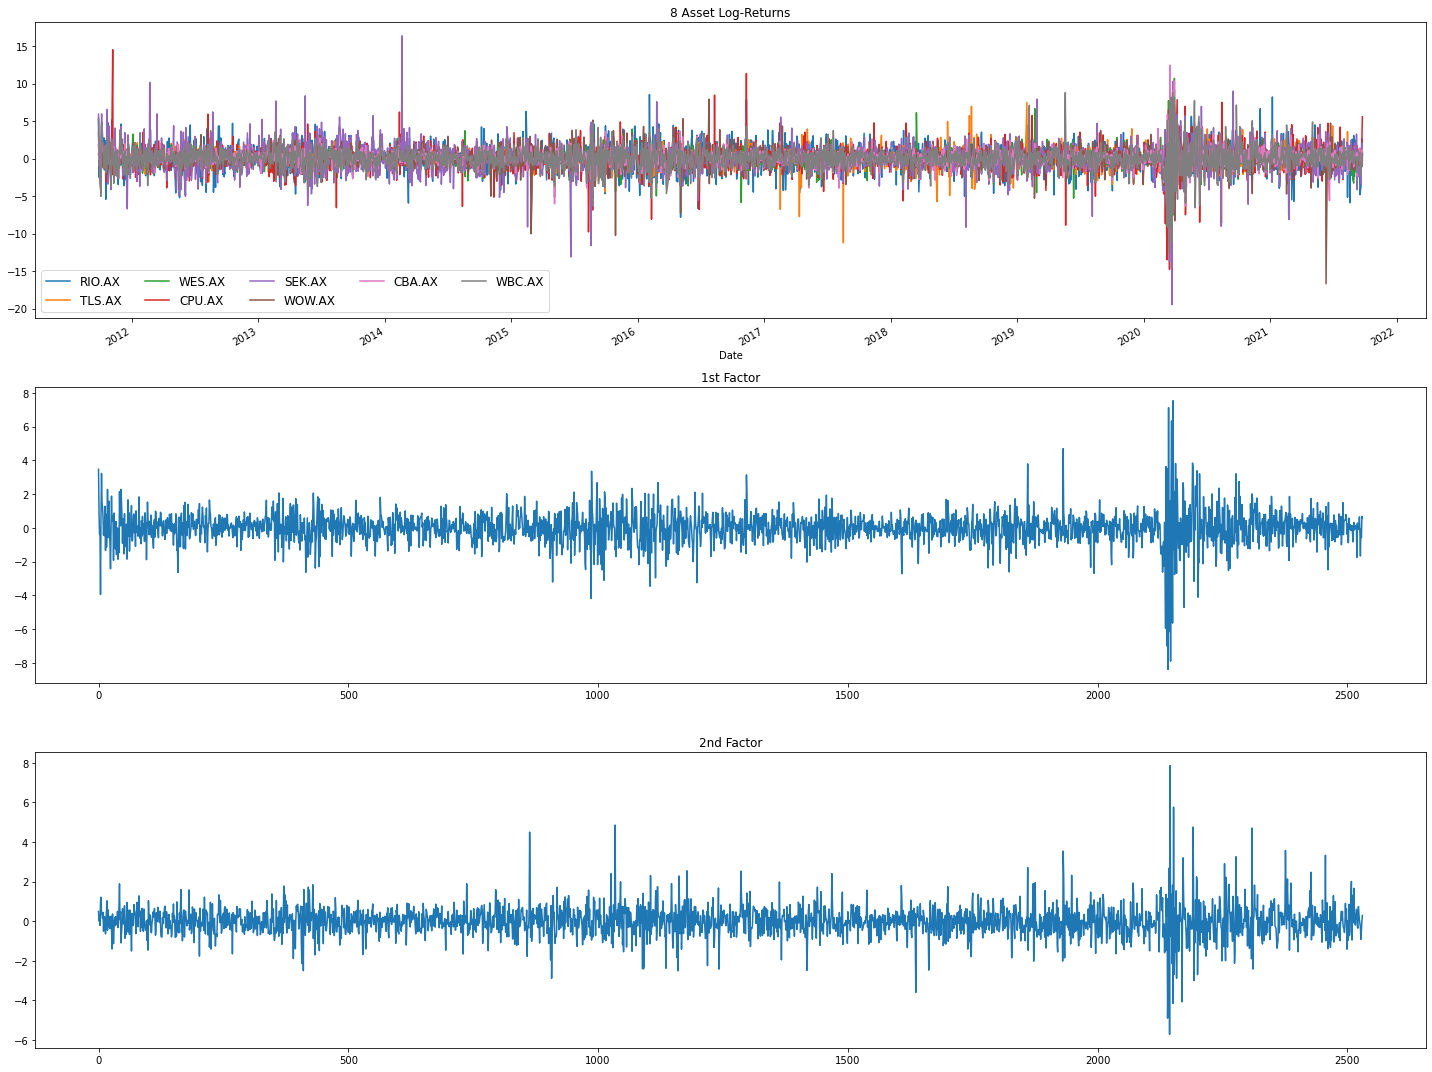

In [185]:
score_2 = result2.factor_scoring(method='regression', transform=True)
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
log_r.plot(ax=ax[0])
ax[0].set_title('8 Asset Log-Returns')
ax[0].legend(loc='best', ncol=5, fontsize=12)
ax[1].plot(score_2[:,0] * (-1))
ax[1].set_title('1st Factor')
ax[2].plot(score_2[:,1])
ax[2].set_title('2nd Factor')
plt.tight_layout()
plt.show()

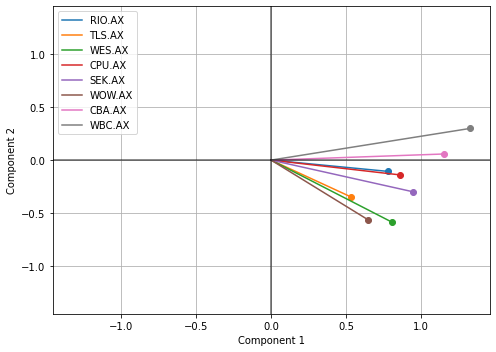

In [186]:
plt.figure(figsize=(7, 5))
biplot(tbl_loading2.values, labels=log_r.columns)
plt.tight_layout()
plt.legend()
plt.show()

In [187]:
ser2_2 = result2.uniqueness * log_r.var() 
ser_2 = np.sqrt(ser2_2)
r2_2 = result2.communality * log_r.var()

tbl_r_2 = pd.DataFrame({'Sample Var': log_r.var().round(4),
                        'Specific Var (m=1)' : ser2.round(4),
                        'Specific Var (m=2)' : ser2_2.round(4),
                        'Communal Var (m=1)': r2.round(4),
                        'Communal Var (m=2)': r2_2.round(4)})
tbl_r_2.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample Var,2.8965,1.4780,1.4819,2.6387,3.6209,1.5931,1.6383,2.0946
Specific Var (m=1),2.2778,1.1916,0.8755,1.8906,2.7118,1.1839,0.2579,0.4910
Specific Var (m=2),2.2793,1.0730,0.4961,1.8813,2.6418,0.8627,0.3176,0.2571
Communal Var (m=1),0.6187,0.2864,0.6065,0.7481,0.9091,0.4092,1.3803,1.6035
Communal Var (m=2),0.6172,0.4050,0.9858,0.7574,0.9791,0.7304,1.3206,1.8374


In [225]:
#Total data variance captured by FM m=2
total_data_variance = np.sum(log_r.var())
total_communal_variance = np.sum(result2.communality * log_r.var())
total_communal_variance / total_data_variance

0.4376235471054291

In [189]:
# standardise data and show correlation matrix
x = (log_r - log_r.mean()) / log_r.std()
x.cov()

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
RIO.AX,1.000000,0.219045,0.313160,0.325313,0.279959,0.259660,0.403502,0.400347
TLS.AX,0.219045,1.000000,0.432200,0.241640,0.238745,0.347203,0.386753,0.338723
WES.AX,0.313160,0.432200,1.000000,0.380599,0.404946,0.557080,0.563177,0.506858
CPU.AX,0.325313,0.241640,0.380599,1.000000,0.408073,0.278818,0.457882,0.462006
SEK.AX,0.279959,0.238745,0.404946,0.408073,1.000000,0.287734,0.432428,0.412324
WOW.AX,0.259660,0.347203,0.557080,0.278818,0.287734,1.000000,0.449792,0.369972
CBA.AX,0.403502,0.386753,0.563177,0.457882,0.432428,0.449792,1.000000,0.829803
WBC.AX,0.400347,0.338723,0.506858,0.462006,0.412324,0.369972,0.829803,1.000000


In [190]:
# show fitted correlation matrix using factor loadings and uniquenesss for statndardised data
result2.fitted_cov

array([[1.00000014, 0.21825188, 0.331496  , 0.2472373 , 0.23655061,
        0.26105573, 0.4072536 , 0.4047977 ],
       [0.21825188, 0.99999953, 0.42641133, 0.25626369, 0.26213021,
        0.35104686, 0.37964222, 0.34065717],
       [0.331496  , 0.42641133, 1.00000006, 0.38984652, 0.40215741,
        0.5501183 , 0.56904862, 0.50245896],
       [0.2472373 , 0.25626369, 0.38984652, 1.00000032, 0.27564781,
        0.30792618, 0.47024555, 0.46519775],
       [0.23655061, 0.26213021, 0.40215741, 0.27564781, 0.99999987,
        0.32269753, 0.43734544, 0.42027642],
       [0.26105573, 0.35104686, 0.5501183 , 0.30792618, 0.32269753,
        1.00000025, 0.436817  , 0.37336488],
       [0.4072536 , 0.37964222, 0.56904862, 0.47024555, 0.43734544,
        0.436817  , 1.00000042, 0.82849322],
       [0.4047977 , 0.34065717, 0.50245896, 0.46519775, 0.42027642,
        0.37336488, 0.82849322, 1.0000004 ]])

In [191]:
Λ = result2.loadings
Ψ = np.diag(result2.uniqueness)

Λ @ Λ.T + Ψ

array([[1.00000014, 0.21825188, 0.331496  , 0.2472373 , 0.23655061,
        0.26105573, 0.4072536 , 0.4047977 ],
       [0.21825188, 0.99999953, 0.42641133, 0.25626369, 0.26213021,
        0.35104686, 0.37964222, 0.34065717],
       [0.331496  , 0.42641133, 1.00000006, 0.38984652, 0.40215741,
        0.5501183 , 0.56904862, 0.50245896],
       [0.2472373 , 0.25626369, 0.38984652, 1.00000032, 0.27564781,
        0.30792618, 0.47024555, 0.46519775],
       [0.23655061, 0.26213021, 0.40215741, 0.27564781, 0.99999987,
        0.32269753, 0.43734544, 0.42027642],
       [0.26105573, 0.35104686, 0.5501183 , 0.30792618, 0.32269753,
        1.00000025, 0.436817  , 0.37336488],
       [0.4072536 , 0.37964222, 0.56904862, 0.47024555, 0.43734544,
        0.436817  , 1.00000042, 0.82849322],
       [0.4047977 , 0.34065717, 0.50245896, 0.46519775, 0.42027642,
        0.37336488, 0.82849322, 1.0000004 ]])

In [192]:
ll_2 = np.log(np.linalg.det(x.cov())) - np.log(np.linalg.det(result2.fitted_cov))

In [229]:
m = 2
T = data.shape[0]
n = data.shape[1]
lr_2 = -(T - 1 - (2 * n + 5) / 6 - 2 * m / 3) * ll_2
df = 0.5 * ((n - m) **2 - n - m )
print(lr_2)
print(df)

151.45926819031536
13.0


In [194]:
# p-value of the test
stats.chi2.sf(lr_2, df)

1.0472640002759633e-25

The null hypothesis is that the $m=2$ factor model is able to model the 5 return series.

### iii) 3 factors (m=3)

In [207]:
fm3 = Factor(endog=log_r, n_factor=3, method='ml')
result3 = fm3.fit()

In [208]:
result3.loadings

array([[-0.46088738, -0.06577492,  0.14638041],
       [-0.43945603, -0.27898013, -0.07522118],
       [-0.66063925, -0.46455258, -0.07039955],
       [-0.54551006, -0.11332958,  0.4235134 ],
       [-0.50457425, -0.17365462,  0.26979743],
       [-0.51350661, -0.4465834 , -0.1320739 ],
       [-0.89775102,  0.05833903, -0.05583145],
       [-0.90889336,  0.21392261, -0.02442379]])

In [215]:
# Actual loadings with Factor 1 by (-1)
tbl_loading3 = pd.DataFrame({'Factor 1': round(result3.loadings[:,0] * log_r.std() * (-1), 4),
                             'Factor 2': round(result3.loadings[:,1] * log_r.std(), 4),
                             'Factor 3': round(result3.loadings[:,2] * log_r.std(), 4)})
tbl_loading3

,Factor 1,Factor 2,Factor 3
RIO.AX,0.7844,-0.1119,0.2491
TLS.AX,0.5343,-0.3392,-0.0914
WES.AX,0.8042,-0.5655,-0.0857
CPU.AX,0.8861,-0.1841,0.6880
SEK.AX,0.9601,-0.3304,0.5134
WOW.AX,0.6481,-0.5637,-0.1667
CBA.AX,1.1491,0.0747,-0.0715
WBC.AX,1.3154,0.3096,-0.0353


In [210]:
ser2_3 = result3.uniqueness * log_r.var() 
ser_3 = np.sqrt(ser2_3)
r2_3 = result3.communality * log_r.var()


tbl_r_3 = pd.DataFrame({'Sample Var': log_r.var().round(4),
                        'Specific Var (m=2)' : ser2_2.round(4),
                        'Specific Var (m=3)' : ser2_3.round(4),
                        'Communal Var (m=2)': r2_2.round(4),
                        'Communal Var (m=3)': r2_3.round(4)})
tbl_r_3.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample Var,2.8965,1.4780,1.4819,2.6387,3.6209,1.5931,1.6383,2.0946
Specific Var (m=2),2.2793,1.0730,0.4961,1.8813,2.6418,0.8627,0.3176,0.2571
Specific Var (m=3),2.2067,1.0692,0.5080,1.3463,2.3263,0.8275,0.3072,0.2672
Communal Var (m=2),0.6172,0.4050,0.9858,0.7574,0.9791,0.7304,1.3206,1.8374
Communal Var (m=3),0.6899,0.4088,0.9739,1.2924,1.2946,0.7656,1.3310,1.8274


In [226]:
#Total data variance captured by FM m=3
total_data_variance = np.sum(log_r.var())
total_communal_variance = np.sum(result3.communality * log_r.var())
total_communal_variance / total_data_variance

0.49212890998734493

In [230]:
ll_3 = np.log(np.linalg.det(x.cov())) - np.log(np.linalg.det(result3.fitted_cov))

In [231]:
m = 3
T = data.shape[0]
n = data.shape[1]
lr_3 = -(T - 1 - (2 * n + 5) / 6 - 2 * m / 3) * ll_2
df = 0.5 * ((n - m) **2 - n - m )
print(lr_3)
print(df)

151.41929741293455
7.0


In [232]:
# p-value of the test
stats.chi2.sf(lr_3, df)

2.043643201902064e-29

### iv) 4 factors (m=4)

In [212]:
fm4 = Factor(endog=log_r, n_factor=4, method='ml')
result4 = fm4.fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/multivariate/factor.py:419: UserWarning: Fitting did not converge
  warnings.warn("Fitting did not converge")


In [213]:
result4.loadings

array([[-4.00919762e-01,  2.19225343e-01, -2.93773331e-02,
         1.65495303e-01],
       [-3.39085013e-01,  3.65640409e-01, -1.24969311e-01,
        -7.60583651e-02],
       [-5.06930736e-01,  5.87569562e-01, -3.04575850e-01,
        -1.10475548e-01],
       [-4.62266958e-01,  2.84457706e-01, -9.70820581e-02,
         4.42682752e-01],
       [-4.12826557e-01,  3.18961632e-01, -9.95959156e-02,
         2.66180375e-01],
       [-3.70215552e-01,  5.07394511e-01, -1.89111542e-01,
        -1.26911516e-01],
       [-8.29942889e-01,  3.75214889e-01,  2.61345963e-01,
        -1.48566198e-02],
       [-1.00023959e+00, -1.85590852e-04, -4.47127939e-05,
        -8.42257811e-06]])

In [216]:
# Actual loadings with Factor 1 by (-1)
tbl_loading4 = pd.DataFrame({'Factor 1': round(result4.loadings[:,0] * log_r.std() * (-1), 4),
                             'Factor 2': round(result4.loadings[:,1] * log_r.std(), 4),
                             'Factor 3': round(result4.loadings[:,2] * log_r.std(), 4),
                             'Factor 4': round(result4.loadings[:,3] * log_r.std(), 4)})
tbl_loading4

,Factor 1,Factor 2,Factor 3,Factor 4
RIO.AX,0.6823,0.3731,-0.0500,0.2817
TLS.AX,0.4122,0.4445,-0.1519,-0.0925
WES.AX,0.6171,0.7153,-0.3708,-0.1345
CPU.AX,0.7509,0.4621,-0.1577,0.7191
SEK.AX,0.7856,0.6069,-0.1895,0.5065
WOW.AX,0.4673,0.6404,-0.2387,-0.1602
CBA.AX,1.0623,0.4803,0.3345,-0.0190
WBC.AX,1.4476,-0.0003,-0.0001,-0.0000


In [223]:
ser2_4 = result4.uniqueness * log_r.var() 
ser_4 = np.sqrt(ser2_4)
r2_4 = result4.communality * log_r.var()


tbl_r_4 = pd.DataFrame({'Sample Var': log_r.var().round(4),
                        'Specific Var (m=3)' : ser2_3.round(4),
                        'Specific Var (m=4)' : ser2_4.round(4),
                        'Communal Var (m=3)': r2_3.round(4),
                        'Communal Var (m=4)': r2_4.round(4)})
tbl_r_4.T

,RIO.AX,TLS.AX,WES.AX,CPU.AX,SEK.AX,WOW.AX,CBA.AX,WBC.AX
Sample Var,2.8965,1.4780,1.4819,2.6387,3.6209,1.5931,1.6383,2.0946
Specific Var (m=3),2.2067,1.0692,0.5080,1.3463,2.3263,0.8275,0.3072,0.2672
Specific Var (m=4),2.2112,1.0789,0.4341,1.3193,2.3452,0.8821,0.1675,0.0001
Communal Var (m=3),0.6899,0.4088,0.9739,1.2924,1.2946,0.7656,1.3310,1.8274
Communal Var (m=4),0.6853,0.3991,1.0478,1.3194,1.2757,0.7110,1.4708,2.0945


In [227]:
#Total data variance captured by FM m=4
total_data_variance = np.sum(log_r.var())
total_communal_variance = np.sum(result4.communality * log_r.var())
total_communal_variance / total_data_variance

0.5162022615682472

## Question 2: Forecasting

In [25]:
# Data seperation

data_new = log_r.iloc[:,1:4]
data_new

,TLS.AX,WES.AX,CPU.AX
Date,,,
2011-09-27,0.655750,3.483130,1.871724
2011-09-28,0.975614,1.040520,0.922870
2011-09-29,0.000000,-0.692494,-0.790514
2011-09-30,0.323089,-0.221343,-1.197638
2011-10-04,-3.278966,-5.031071,-4.238481
...,...,...,...
2021-09-20,-1.025649,-0.665613,-2.247279
2021-09-21,1.280426,0.857469,1.402887
2021-09-22,0.507615,-0.279183,-1.096237


In [26]:
# No. of forecasts 
r = data_new
n_all = len(r)
n_wind = 2000 #fixed window for data
n_forecast = len(r) - n_wind
print(n_forecast)

531


In [27]:
# Model 4 Regression for Asset 1
x = log_r.iloc[:-n_forecast-1,0].values #lagged one return
y = r.iloc[1:-n_forecast,0].values
reg_TLS = ARIMA(y, exog=x,order=(0,0,0)).fit()
print(reg_TLS.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1999
Model:                          ARIMA   Log Likelihood               -3077.622
Date:                Mon, 04 Oct 2021   AIC                           6161.243
Time:                        17:02:42   BIC                           6178.045
Sample:                             0   HQIC                          6167.413
                               - 1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0313      0.026      1.212      0.225      -0.019       0.082
x1            -0.0321      0.015     -2.183      0.029      -0.061      -0.003
sigma2         1.2729      0.017     73.254      0.0

In [28]:
# Model 4 Regression for Asset 2
x = log_r.iloc[:-n_forecast-1,0].values #lagged one return
y = r.iloc[1:-n_forecast,1].values
reg_WES = ARIMA(y, exog=x,order=(0,0,0)).fit()
print(reg_WES.summary()) 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1999
Model:                          ARIMA   Log Likelihood               -2978.246
Date:                Mon, 04 Oct 2021   AIC                           5962.492
Time:                        17:02:44   BIC                           5979.294
Sample:                             0   HQIC                          5968.662
                               - 1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0496      0.024      2.059      0.039       0.002       0.097
x1             0.0226      0.013      1.688      0.091      -0.004       0.049
sigma2         1.1524      0.022     51.465      0.0

In [29]:
# Model 4 Regression for Asset 3
x = log_r.iloc[:-n_forecast-1,0].values #lagged one return
y = r.iloc[1:-n_forecast,2].values
reg_CPU = ARIMA(y, exog=x,order=(0,0,0)).fit()
print(reg_CPU.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1999
Model:                          ARIMA   Log Likelihood               -3594.597
Date:                Mon, 04 Oct 2021   AIC                           7195.194
Time:                        17:02:45   BIC                           7211.995
Sample:                             0   HQIC                          7201.363
                               - 1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0451      0.033      1.372      0.170      -0.019       0.110
x1             0.0200      0.016      1.235      0.217      -0.012       0.052
sigma2         2.1351      0.029     74.567      0.0

## Forecasting models for Asset 1

In [ ]:
fnaive_TLS = np.empty(n_forecast)
f15days_TLS = np.empty(n_forecast)
farma_TLS = np.empty(n_forecast)
freg_TLS = np.empty(n_forecast)

from tqdm.notebook import tqdm  #indicate progress

for i in tqdm(range(n_forecast)):    #moving data window
    y = r.iloc[(i + 1):(-n_forecast + i),0].values
    x = log_r.iloc[i:(-n_forecast+i-1),0].values 
    x_new = log_r.iloc[(-n_forecast+i-1),0]
    

#Naive forecasting
fnaive_TLS[i] = y[-1]
#15 days average
f15days_TLS[i] = y[-15:].mean()
#ARMA(1,1)
arma_TLS = ARIMA(y,order=(1,0,1)).fit()
#Regression
reg_TLS = ARIMA(y,exog=x ,order=(0,0,0)).fit()

# Results of ARMA and Regression models
freg_TLS[i] = reg_TLS.forecast(exog = x_new, step=1)
farma_TLS[i] = arma_TLS.forecast(step=1)

#Model 5
ffc_TLS = (f15days_TLS+farma_TLS+freg_TLS)/3

In [53]:
#Accuracy measures

def loss_func(y_obs, y_hat):
    rmse = np.sort(np.mean((y_hat - y_obs) ** 2))
    mad = np.mean(np.abs(y_hat - y_obs))
    return(rmse, mad)

In [ ]:
f_TLS = np.vstack([fnaive_TLS, f15days_TLS, farma_TLS, freg_TLS,ffc_TLS]).T

l = np.empty((2,5))

for i in range(5):
    l[0,i],l[1,i] = loss_func(r.iloc[-n_forecast:,0].values, f_TLS[:,i])
c_name = ['Native', '15days', 'ARMA(1,1)', 'Reg', 'Combine Average']
tbl_TLS = pd.DataFrame(l.round(4), columns = c_name, index=['RMSE', 'MAD'])                          
tbl_TLS      

In [ ]:
#M-Z Regression
fr_TLS = r.iloc[-n_forecast:, 0]

dff_TLS = pd.DataFrame({
    'r_TLS_real': fr_TLS,
    'r_TLS_native': f_TLS[:,0],
    'r_TLS_15days': f_TLS[:,1],
    'r_TLS_arma11': f_TLS[:,2],
    'r_TLS_reg': f_TLS[:,3],
    'r_TLS_fm': f_TLS[:,4]})
dff_TLS

## Forecasting models for Asset 2

In [ ]:
fnaive_WES = np.empty(n_forecast)
f15days_WES = np.empty(n_forecast)
farma_WES = np.empty(n_forecast)
freg_WES = np.empty(n_forecast)

from tqdm.notebook import tqdm  #indicate progress

for i in tqdm(range(n_forecast)):    #moving data window
    y = r.iloc[(i + 1):(-n_forecast + i),0].values
    x = log_r.iloc[i:(-n_forecast+i-1),0].values 
    x_new = log_r.iloc[(-n_forecast+i-1),0]
    

#Naive forecasting
fnaive_WES[i] = y[-1]
#15 days average
f15days_WES[i] = y[-15:].mean()
#ARMA(1,1)
arma_WES = ARIMA(y,order=(1,0,1)).fit()
#Regression
reg_WES = ARIMA(y,exog=x ,order=(0,0,0)).fit()

# Results of ARMA and Regression models
freg_WES[i] = reg_WES.forecast(exog = x_new, step=1)
farma_WES[i] = arma_WES.forecast(step=1)

#Model 5
ffc_WES = (f15days_WES+farma_WES+freg_WES)/3

In [ ]:
f_WES = np.vstack([fnaive_WES, f15days_WES, farma_WES, freg_WES,ffc_WES]).T

l = np.empty((2,5))

for i in range(5):
    l[0,i],l[1,i] = loss_func(r.iloc[-n_forecast:,0].values, f_TLS[:,i])
c_name = ['Native', '15days', 'ARMA(1,1)', 'Reg', 'Combine Average']
tbl_WES = pd.DataFrame(l.round(4), columns = c_name, index=['RMSE', 'MAD'])                          
tbl_WES  

In [ ]:
#M-Z Regression
fr_WES = r.iloc[-n_forecast:, 0]

dff_WES = pd.DataFrame({
    'r_WES_real': fr_WES,
    'r_WES_native': f_WES[:,0],
    'r_WES_15days': f_WES[:,1],
    'r_WES_arma11': f_WES[:,2],
    'r_WES_reg': f_WES[:,3],
    'r_WES_fm': f_WES[:,4]})
dff_WES

## Forecasting models for Asset 3

In [ ]:
fnaive_CPU = np.empty(n_forecast)
f15days_CPU = np.empty(n_forecast)
farma_CPU = np.empty(n_forecast)
freg_CPU = np.empty(n_forecast)

from tqdm.notebook import tqdm  #indicate progress

for i in tqdm(range(n_forecast)):    #moving data window
    y = r.iloc[(i + 1):(-n_forecast + i),0].values
    x = log_r.iloc[i:(-n_forecast+i-1),0].values 
    x_new = log_r.iloc[(-n_forecast+i-1),0]
    

#Naive forecasting
fnaive_CPU[i] = y[-1]
#15 days average
f15days_CPU[i] = y[-15:].mean()
#ARMA(1,1)
arma_CPU = ARIMA(y,order=(1,0,1)).fit()
#Regression
reg_CPU = ARIMA(y,exog=x ,order=(0,0,0)).fit()

# Results of ARMA and Regression models
freg_CPU[i] = reg_CPU.forecast(exog = x_new, step=1)
farma_CPU[i] = arma_CPU.forecast(step=1)

#Model 5
ffc_CPU = (f15days_CPU+farma_CPU+freg_CPU)/3

In [ ]:
f_CPU = np.vstack([fnaive_CPU, f15days_CPU, farma_CPU, freg_CPU,ffc_CPU]).T

l = np.empty((2,5))

for i in range(5):
    l[0,i],l[1,i] = loss_func(r.iloc[-n_forecast:,0].values, f_TLS[:,i])
c_name = ['Native', '15days', 'ARMA(1,1)', 'Reg', 'Combine Average']
tbl_CPU = pd.DataFrame(l.round(4), columns = c_name, index=['RMSE', 'MAD'])                          
tbl_CPU 

In [ ]:
#M-Z Regression
fr_CPU = r.iloc[-n_forecast:, 0]

dff_CPU = pd.DataFrame({
    'r_CPU_real': fr_CPU,
    'r_CPU_native': f_CPU[:,0],
    'r_CPU_15days': f_CPU[:,1],
    'r_CPU_arma11': f_CPU[:,2],
    'r_CPU_reg': f_CPU[:,3],
    'r_CPU_fm': f_CPU[:,4]})
dff_CPU

## Question 2: Weights

In [60]:
#Strategy 1

r_fore = r.iloc[-n_forecast:, :]
r_eq_wt = np.mean(r_fore, axis=1)
mn_eq_wt = np.mean(r_eq_wt)
sd_eq_wt = np.std(r_eq_wt, ddof=1)
print(mn_eq_wt)
print(sd_eq_wt)

0.04891324814834484
1.4078813254351055


In [ ]:
std22 = np.empty((n_forecast, 3))
for i in range(n_forecast):
    std22[i,;]=np.std(r,iloc[(2000+i-22):(2000+i)],axis=0,ddof=1)
std22
    

In [ ]:
#Strategy 3
t1 = 1 / std22
t2 = np.sum(t1, axis=1)
w = t1 / t2.reshape(-1,1)
r_invp_ret = np.sum(r_fore.values * w, axis = 1)

mn_invp_ret = np.mean(r_invp_ret, axis=0)
sd_invp_ret = np.std(r_invp_ret, axis=0, ddof=1)
print(mn_invp_ret)
print(sd_invp_ret)

In [61]:
#Strategy 2

f_all = np.empty((n_forecast, 5, 3))
f_all[:, :, 0] = f_TLS
f_all[:, :, 1] = f_WES
f_all[:, :, 2] = f_CPU

r_prop_ret = np.empty((n_forecast, 5))
w = np.empty((n_forecast, 3))
for i in range(5):
    r_sum = np.sum(f_all[:, i, :], axis=1)
    w = f_all[:, i, :] / r_sum.reshape(-1, 1)
    r_prop_ret[:, i] = np.sum(r_fore.values * w, axis=1)
mn_prop_ret = np.mean(r_prop_ret, axis=0)
sd_prop_ret = np.std(r_prop_ret, axis=0, ddof=1)
print(mn_prop_ret)
print(sd_prop_ret)

NameError: name 'f_TLS' is not defined

In [ ]:
p_mn = np.hstack((mn_eq_wt, mn_prop_ret, mn_invp_ret))
p_sd = np.hstack((sd_eq_wt, sd_prop_ret, sd_invp_ret))
tbl_port=pd.DataFrame(np.vstack((p_mn,p_sd)), index = ('mean return', 'standard deviation'),
                                              columns = ('Equal Weight', 'FR_Naive','FR_15days','FR_ARMA11','FR_Reg','FR_FM','Inversely SD'))
tbl_port.loc['mean/sd',:]=tbl_port.loc['mean return']/tbl_port.loc['standard deviation']
tbl_port                                

In [ ]:
pd.DataFrame.max(tbl_port.iloc[[0,2]:],axis=1)
pd.DataFrame.min(tbl.port.iloc[1,:])